# Prompt Engineering for `ImageNet-Hard`

<a target="_blank" href="https://colab.research.google.com/github/taesiri/ZoomIsAllYouNeed/blob/main/src/ImageNet_Hard/Prompt_Engineering_for_ImageNet_Hard.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

* [Website](https://taesiri.github.io/ZoomIsAllYouNeed/)
* [Github](https://github.com/taesiri/ZoomIsAllYouNeed)

### Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [30]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git
! pip install transformers datasets

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-f3ekh4yt
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-f3ekh4yt
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done


In [31]:
import clip
import numpy as np
import torch
from tqdm import tqdm
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import requests

sns.set_style("whitegrid")


In [32]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(device=0))
print(torch.__version__)

8
NVIDIA A100-SXM4-40GB
1.11.0


# Loading the model

Download and instantiate a CLIP model using the `clip` module that we just installed.

In [33]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [34]:
model, preprocess = clip.load("ViT-L/14")

In [35]:
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print(
    "Model parameters:",
    f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}",
)
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 427,616,513
Input resolution: 224
Context length: 77
Vocab size: 49408


## Preparing ImageNet labels and prompts

The following cell contains the 1,000 labels for the ImageNet dataset, followed by the text templates we'll use as "prompt engineering".

In [36]:
url = "https://gist.githubusercontent.com/taesiri/5b5edb5452f2f20d82d5ed1bb58ab574/raw/0376003d3999799f99208fb338cfd06ee44372b5/imagenet-labels.json"

response = requests.get(url)

if response.status_code == 200:
    imagenet_classes = response.json()

A subset of these class names are modified from the default ImageNet class names sourced from Anish Athalye's imagenet-simple-labels.

These edits were made via trial and error and concentrated on the lowest performing classes according to top_1 and top_5 accuracy on the ImageNet training set for the RN50, RN101, and RN50x4 models. These tweaks improve top_1 by 1.5% on ViT-B/32 over using the default class names. Alec got bored somewhere along the way as gains started to diminish and never finished updating / tweaking the list. He also didn't revisit this with the better performing RN50x16, RN50x64, or any of the ViT models. He thinks it's likely another 0.5% to 1% top_1 could be gained from further work here. It'd be interesting to more rigorously study / understand this.

Some examples beyond the crane/crane -> construction crane / bird crane issue mentioned in Section 3.1.4 of the paper include:

- CLIP interprets "nail" as "fingernail" so we changed the label to "metal nail".
- ImageNet kite class refers to the bird of prey, not the flying toy, so we changed "kite" to "kite (bird of prey)"
- The ImageNet class for red wolf seems to include a lot of mislabeled maned wolfs so we changed "red wolf" to "red wolf or maned wolf"

In [37]:
imagenet_templates = [
    "a bad photo of a {}.",
    "a photo of many {}.",
    "a sculpture of a {}.",
    "a photo of the hard to see {}.",
    "a low resolution photo of the {}.",
    "a rendering of a {}.",
    "graffiti of a {}.",
    "a bad photo of the {}.",
    "a cropped photo of the {}.",
    "a tattoo of a {}.",
    "the embroidered {}.",
    "a photo of a hard to see {}.",
    "a bright photo of a {}.",
    "a photo of a clean {}.",
    "a photo of a dirty {}.",
    "a dark photo of the {}.",
    "a drawing of a {}.",
    "a photo of my {}.",
    "the plastic {}.",
    "a photo of the cool {}.",
    "a close-up photo of a {}.",
    "a black and white photo of the {}.",
    "a painting of the {}.",
    "a painting of a {}.",
    "a pixelated photo of the {}.",
    "a sculpture of the {}.",
    "a bright photo of the {}.",
    "a cropped photo of a {}.",
    "a plastic {}.",
    "a photo of the dirty {}.",
    "a jpeg corrupted photo of a {}.",
    "a blurry photo of the {}.",
    "a photo of the {}.",
    "a good photo of the {}.",
    "a rendering of the {}.",
    "a {} in a video game.",
    "a photo of one {}.",
    "a doodle of a {}.",
    "a close-up photo of the {}.",
    "a photo of a {}.",
    "the origami {}.",
    "the {} in a video game.",
    "a sketch of a {}.",
    "a doodle of the {}.",
    "a origami {}.",
    "a low resolution photo of a {}.",
    "the toy {}.",
    "a rendition of the {}.",
    "a photo of the clean {}.",
    "a photo of a large {}.",
    "a rendition of a {}.",
    "a photo of a nice {}.",
    "a photo of a weird {}.",
    "a blurry photo of a {}.",
    "a cartoon {}.",
    "art of a {}.",
    "a sketch of the {}.",
    "a embroidered {}.",
    "a pixelated photo of a {}.",
    "itap of the {}.",
    "a jpeg corrupted photo of the {}.",
    "a good photo of a {}.",
    "a plushie {}.",
    "a photo of the nice {}.",
    "a photo of the small {}.",
    "a photo of the weird {}.",
    "the cartoon {}.",
    "art of the {}.",
    "a drawing of the {}.",
    "a photo of the large {}.",
    "a black and white photo of a {}.",
    "the plushie {}.",
    "a dark photo of a {}.",
    "itap of a {}.",
    "graffiti of the {}.",
    "a toy {}.",
    "itap of my {}.",
    "a photo of a cool {}.",
    "a photo of a small {}.",
    "a tattoo of the {}.",
]

print(f"{len(imagenet_classes)} classes, {len(imagenet_templates)} templates")

1000 classes, 80 templates


## Loading Data

In [38]:
from torch.utils.data import DataLoader
from datasets import load_dataset

In [39]:
imagenet_hard_dataset = load_dataset('taesiri/imagenet-hard', split='validation')
imagenet_hard_dataset

Found cached dataset parquet (/home/mohammad/.cache/huggingface/datasets/taesiri___parquet/taesiri--imagenet-hard-f9d3853f5743f3a3/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


Dataset({
    features: ['image', 'label', 'origin', 'english_label'],
    num_rows: 13053
})

In [40]:
def apply_transforms(examples):
    examples["pixel_values"] =examples["image"]
    examples["image"] = [preprocess(image) for image in examples["image"]]
    return examples

imagenet_hard_dataset.set_transform(apply_transforms)

## Creating zero-shot classifier weights

In [41]:
def zeroshot_classifier(classnames, templates):
    with torch.no_grad():
        zeroshot_weights = []
        for classname in tqdm(classnames):
            texts = [
                template.format(classname) for template in templates
            ]  # format with class
            texts = clip.tokenize(texts).cuda()  # tokenize
            class_embeddings = model.encode_text(texts)  # embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)

            class_embedding = class_embeddings.mean(
                dim=0
            )  # Mean of 80 Different Templates

            class_embedding /= class_embedding.norm()
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
    return zeroshot_weights


zeroshot_weights = zeroshot_classifier(imagenet_classes, imagenet_templates)

100%|██████████| 1000/1000 [00:24<00:00, 41.45it/s]


## Zero-shot prediction

In [42]:
def accuracy(output, target, topk=(1,)):
    pred = output.topk(max(topk), 1, True, True)[1].t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    return [
        float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy())
        for k in topk
    ]

In [43]:
def collate_fn(batch):
    return {
        'image': torch.stack([item['image'] for item in batch]),
        'label': torch.tensor([item['label'] for item in batch]),
    }

loader = DataLoader(imagenet_hard_dataset, batch_size=32, num_workers=2, collate_fn=collate_fn)

with torch.no_grad():
    top1, top5, n = 0.0, 0.0, 0.0
    for i, (batch) in enumerate(tqdm(loader)):
        images, target = batch['image'], batch['label']
        images = images.cuda()
        target = target.cuda()

        # predict
        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        logits = 100.0 * image_features @ zeroshot_weights

        # measure accuracy
        acc1, acc5 = accuracy(logits, target, topk=(1, 5))
        
        top1 += acc1
        top5 += acc5
        n += images.size(0)

top1 = (top1 / n) * 100
top5 = (top5 / n) * 100

print(f"Top-1 accuracy: {top1:.2f}")
print(f"Top-5 accuracy: {top5:.2f}")

100%|██████████| 408/408 [03:07<00:00,  2.17it/s]

Top-1 accuracy: 3.30
Top-5 accuracy: 29.83


## Visualizations

In [44]:
url = "https://gist.githubusercontent.com/taesiri/5b5edb5452f2f20d82d5ed1bb58ab574/raw/0376003d3999799f99208fb338cfd06ee44372b5/imagenet-labels.json"

response = requests.get(url)

if response.status_code == 200:
    id_class = response.json()

id_class = {i: v for i, v in enumerate(id_class)}

format_str = (
    lambda x: x.replace("_", " ")
    .replace("-", " ")
    .replace("(", "")
    .replace(")", "")
    .replace("  ", " ")
    .strip()
    .lower()
)
id_class = {int(k): format_str(v) for k, v in id_class.items()}


In [45]:
def predict(image, k=5):
    image = image.unsqueeze(0).cuda()
    with torch.no_grad():
        image_features = model.encode_image(image)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    logits = 100.0 * image_features @ zeroshot_weights
    probs = logits.softmax(dim=-1)
    values, indices = probs.topk(k, dim=-1)
    values, indices = values.cpu().numpy(), indices.cpu().numpy()
    return values, indices

In [46]:
def plot_image(IID):
    sc = 1.5

    image = imagenet_hard_dataset[IID]["pixel_values"]
    gt_label = imagenet_hard_dataset[IID]['english_label']
    gt_label = format_str(gt_label)
    probs, indices = predict(imagenet_hard_dataset[IID]["image"])
    labels = [id_class[i] for i in indices[0]]

    fig, axes = plt.subplots(
        1, 2, figsize=(10 * sc, 3 * sc), gridspec_kw={"width_ratios": [2, 1]}
    )
    axes[0].imshow(image)
    axes[0].axis("off")

    data = pd.DataFrame({"label": labels, "probability": probs[0]})
    sns.barplot(
        x="probability",
        y="label",
        data=data,
        ax=axes[1],
        orient="h",
        order=data.sort_values("probability", ascending=False)["label"],
        alpha=0.8,
        edgecolor="black",
        linewidth=1,
        saturation=1,
        errcolor="black",
    )

    axes[1].set_xlim(0, 1)

    axes[1].set_ylim(axes[1].get_ylim()[0] + 1, axes[1].get_ylim()[1] - 1)
    axes[1].spines["top"].set_visible(False)
    axes[1].spines["bottom"].set_visible(False)

    fig.suptitle(
        f"Ground Truth: {gt_label}",
        fontsize=16,
        ha="left",
        color="black",
        fontweight="bold",
        fontstyle="italic",
    )

    plt.tight_layout()
    plt.show()


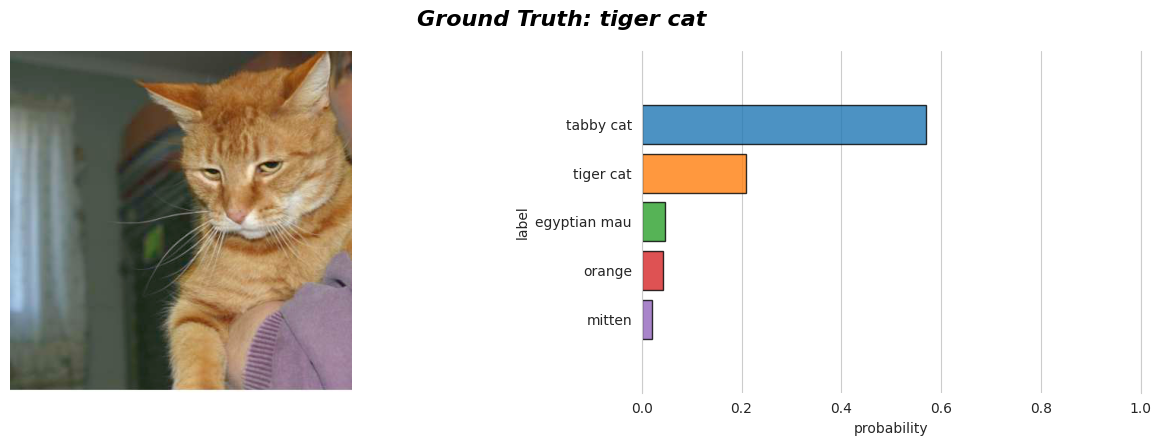

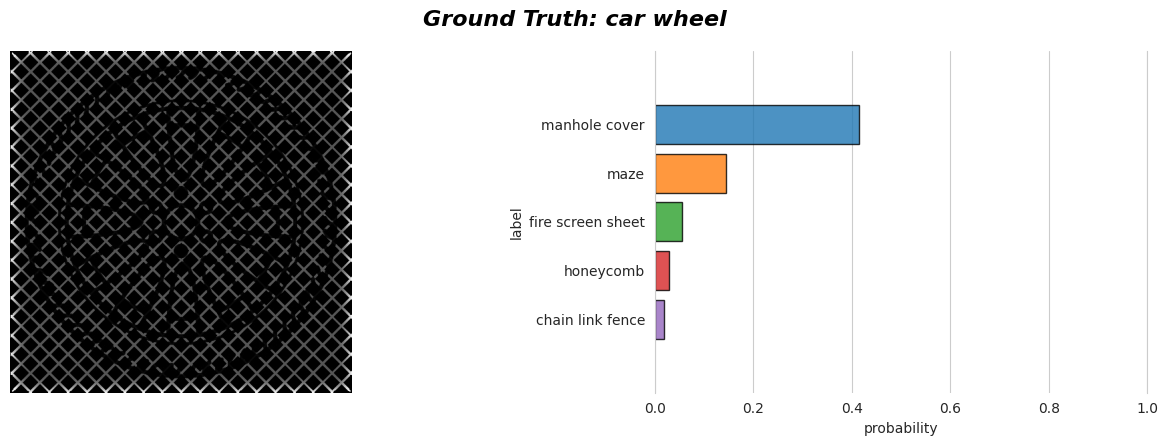

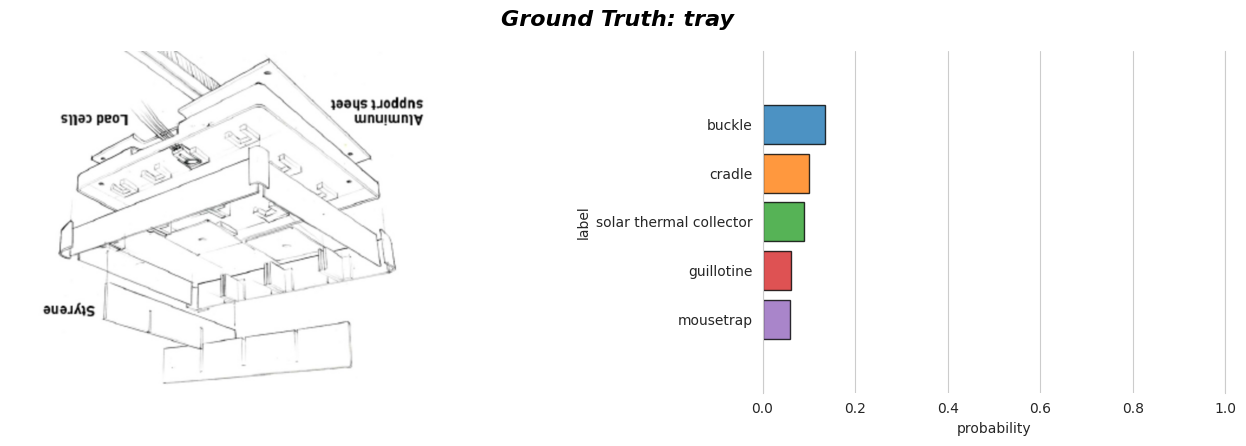

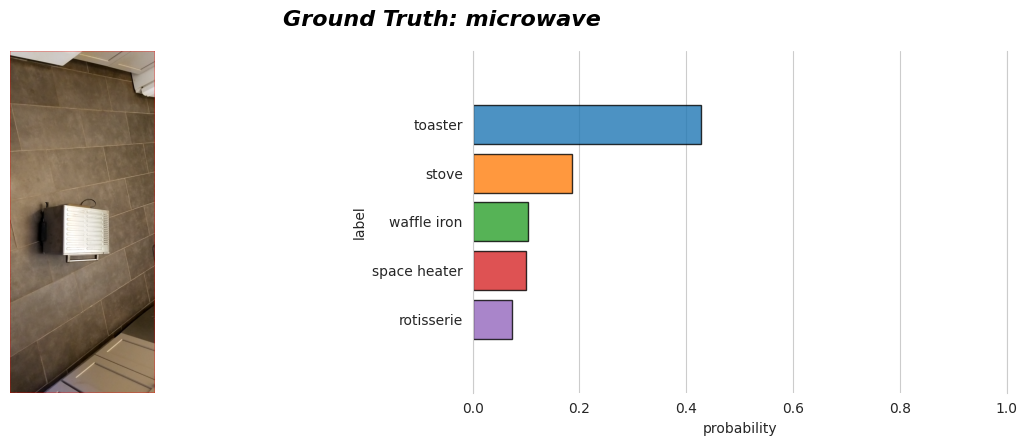

In [47]:
for i in np.random.randint(0, len(imagenet_hard_dataset), 4):
    plot_image(int(i))